In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Trabalho 2 - MAP e Logistica Baysiana
Aluno: Diego Freitas Holanda

Matricula: 411627

In [220]:
dataset = np.genfromtxt('./logistic_regression_data.csv', delimiter=',')
x = dataset[:, :-1]
y = dataset[:, [-1]]
COLOR_MAP = 'RdBu'

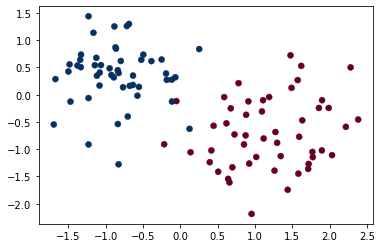

In [221]:
plt.scatter(x[:, 0], x[:, 1], c=y, linewidths=.5, cmap=COLOR_MAP);

In [222]:
def plot_discrete_space(xmin, xmax, ymin, ymax, resolution, color_function):
    x1 = np.linspace(xmin, xmax, resolution)
    x2 = np.linspace(ymin, ymax, resolution)
    x1, x2 = np.meshgrid(x1, x2)
    grid = np.vstack([x1.reshape(-1), x2.reshape(-1)]).T
    plt.scatter(grid[:, 0], grid[:, 1], c=color_function(grid), cmap=COLOR_MAP);

In [223]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

# Algoritmo IRLS

In [224]:
class IRLS:
    
    def __init__(self, prior_mean, prior_var, max_iter=10, conv=1e-5):
        self.prior_mean = prior_mean
        self.prior_var = prior_var
        self.max_iter = max_iter
        self.conv = conv
    
    def fit(self, X, y):
        self.w = np.ones((X.shape[1], 1))
        self.norms = [np.linalg.norm(self.w)]
        inv_var = np.linalg.inv(self.prior_var)
        delta = 1
        i = 0
        while(delta >= self.conv and i < self.max_iter):
            x_eq = (X.T @ (y - sigma(X @ self.w))) - (inv_var @ (self.w - self.prior_mean))
            R = np.array([sigma(self.w.T @ x)*(1 - sigma(self.w.T @ x)) for x in X]).flatten()
            R = R * np.eye(len(R))
            A = X.T @ R @ X + inv_var
            
            self.w += np.linalg.inv(A) @ x_eq
            
            w_norm = np.linalg.norm(self.w)
            delta = abs(w_norm - self.norms[-1])
            
            self.norms.append(w_norm)
            i += 1
        
        return self.w
                
    def predict(self, x):
        return sigma(x @ self.w)       

In [225]:
map_model = IRLS(np.zeros((x.shape[1], 1)), np.eye(x.shape[1]))
map_model.fit(x, y)

array([[-2.86937881],
       [ 1.33323317]])

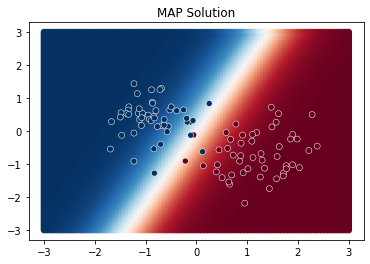

In [226]:
plot_discrete_space(-3, 3, -3, 3, 100, map_model.predict)
plt.title('MAP Solution');

# Modelo Baysiano Logistico

In [227]:
class LogisticBaysian:
    
    def __init__(self, prior_mean, prior_var, n_iter=10):
        self.prior_mean = prior_mean
        self.prior_var = prior_var
        self.n_iter = n_iter
        
    def fit(self, X, y):
        w_hat = IRLS(self.prior_mean, self.prior_var, self.n_iter).fit(X, y)
        R = np.array([sigma(w_hat.T @ x)*(1 - sigma(w_hat.T @ x)) for x in X]).flatten()
        R = R * np.eye(len(R))
        H = X.T @ R @ X + np.linalg.inv(self.prior_var)
        self.post_mean = w_hat
        self.post_var = np.linalg.inv(H)
        
        return self.post_mean, self.post_var
    
    def predict_probit(self, X):
        mu = X @ self.post_mean
        sigma_a = np.vstack([x @ self.post_var @ x.T for x in X])
        return sigma(((1 + np.pi*sigma_a/8)**(1/2)) * mu)

In [228]:
logistic = LogisticBaysian(np.zeros((x.shape[1], 1)), np.eye(x.shape[1]))
logistic.fit(x, y)

(array([[-2.86937881],
        [ 1.33323317]]),
 array([[0.29709322, 0.02932676],
        [0.02932676, 0.31406166]]))

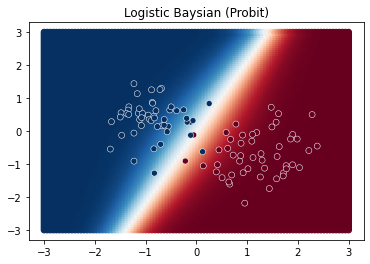

In [229]:
plot_discrete_space(-3, 3, -3, 3, 100, logistic.predict_probit)
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='white', linewidths=.5, cmap=COLOR_MAP);
plt.title('Logistic Baysian (Probit)');